In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob, re, json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm, SymLogNorm, CenteredNorm
from censai.data.lenses_tng import decode_train, decode_physical_model_info
from censai import PhysicalModel
from argparse import Namespace
from argparse import Namespace
import math, json
import matplotlib.pylab as pylab
import tensorflow as tf
import h5py
from tqdm import tqdm

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)
pd.set_option('display.max_colwidth', 200)

result_dir = os.path.join(os.getenv("CENSAI_PATH"), "results")
data_path = os.path.join(os.getenv("CENSAI_PATH"), "data")
models_path = os.path.join(os.getenv("CENSAI_PATH"), "models")

params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (10, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize': 30,#'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
# plt.style.use("science")

In [4]:
# model = "RIMSU512_k128_NIE2nsvdO_033_TS10_F16_L5_IK11_NLrelu_al0.04_GAplus_42_B10_lr0.0005_dr0.8_ds5000_TWquadratic_210923032150"
model = "RIMSU128_hTNG2nsvdO_Sinit1_001_F16_IK11_NLleaky_relu_128_211012121338"
path = os.path.join(os.getenv("CENSAI_PATH"), "data", "rim_predictions", model, "predictions.h5")
hf = h5py.File(path, 'r')
k = 8

lens = np.array(hf[f"data{k:03d}/lens"]).squeeze()
source = np.array(hf[f"data{k:03d}/source"]).squeeze()
kappa = np.array(hf[f"data{k:03d}/kappa"]).squeeze()
lens_pred = np.array(hf[f"data{k:03d}/lens_pred"]).squeeze()
source_pred = np.array(hf[f"data{k:03d}/source_pred"]).squeeze()[-1]
kappa_pred = np.array(hf[f"data{k:03d}/kappa_pred"]).squeeze()[-1]
chi_squared = np.array(hf[f"data{k:03d}/chi_squared"]).squeeze()[-1]

hf.close();

In [6]:
# fig, axs = plt.subplots(1, 9, figsize=(36, 4))

# axs[0].imshow(source, cmap="bone", origin="lower")
# axs[1].imshow(source_pred, cmap="bone", origin="lower")
# axs[2].imshow(source - source_pred, cmap="seismic", norm=CenteredNorm(), origin="lower")

# axs[3].imshow(kappa, cmap="hot", norm=LogNorm(vmin=5e-2), origin="lower")
# axs[4].imshow(kappa_pred, cmap="hot", norm=LogNorm(vmin=5e-2), origin="lower")
# axs[5].imshow(kappa - kappa_pred, cmap="seismic", norm=SymLogNorm(linthresh=1e-1, base=10, vmax=100, vmin=-100), origin="lower")

# axs[6].imshow(lens, cmap="bone", origin="lower")
# axs[7].imshow(lens_pred, cmap="bone", origin="lower")
# axs[8].imshow(lens - lens_pred, cmap="seismic", norm=CenteredNorm(), origin="lower")

# for j in range(9):
#     axs[j].axis("off")


# axs[0, 0].set_title("Source")
# axs[0, 1].set_title("Source prédite")
# axs[0, 2].set_title("Différence")
# axs[0, 3].set_title("$\kappa$")
# axs[0, 4].set_title("$\hat{\kappa}_T$")
# axs[0, 5].set_title("$\kappa - \hat{\kappa}_T$")
# axs[0, 6].set_title("Observation ($\mathbf{y}$)")
# axs[0, 7].set_title("Prédiction ($\mathbf{\hat{y}}_T$)")
# axs[0, 8].set_title("$\mathbf{y} - \mathbf{\hat{y}}_T$")
plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig(f"rim_pred{start:d}.png")

<Figure size 432x288 with 0 Axes>

In [8]:
# dataset = "lenses512_hk128_TNG100_10k_verydiffuse"

# files = []
# for dataset in [os.path.join(os.getenv('CENSAI_PATH'), "data", dataset)][:1]:
#     files.extend(glob.glob(os.path.join(dataset, "*.tfrecords")))
# np.random.shuffle(files)
# # Read concurrently from multiple records
# files = tf.data.Dataset.from_tensor_slices(files)
# dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type="GZIP"),
#                            block_length=1, num_parallel_calls=tf.data.AUTOTUNE)
# # Read off global parameters from first example in dataset
# for physical_params in dataset.map(decode_physical_model_info):
#     break

# phys = PhysicalModel(
#     pixels=physical_params["pixels"].numpy(),
#     kappa_pixels=physical_params["kappa pixels"].numpy(),
#     src_pixels=physical_params["src pixels"].numpy(),
#     image_fov=physical_params["image fov"].numpy(),
#     kappa_fov=physical_params["kappa fov"].numpy(),
#     src_fov=physical_params["source fov"].numpy(),
#     method="fft",
#     noise_rms=physical_params["noise rms"].numpy(),
#     psf_sigma=physical_params["psf sigma"].numpy()
# )



In [298]:
DTYPE = tf.float32
STEPS = 100
SAVE = 10

optim = tf.keras.optimizers.Adam(lr=1e-4)
source_o = tf.Variable(tf.identity(source_pred)[None, ..., None], DTYPE)
kappa_o = tf.Variable((tf.math.log(tf.identity(kappa_pred)[None, ..., None], DTYPE) + 1e-6)/tf.math.log(10.))
lensed_image = lens

source_series = tf.TensorArray(DTYPE, size=STEPS//SAVE+1)
kappa_series = tf.TensorArray(DTYPE, size=STEPS//SAVE+1)
chi_squared_series = tf.TensorArray(DTYPE, size=STEPS//SAVE+1)
lens_series = tf.TensorArray(DTYPE, size=STEPS//SAVE+1)
for current_step in tqdm(range(STEPS)):
    with tf.GradientTape() as g:
        g.watch(source_o)
        g.watch(kappa_o)
        y_pred = phys.forward(source=source_o, kappa=10**kappa_o)
#         lam = tf.reduce_sum(y_pred * lensed_image[None, ..., None]) / tf.reduce_sum(lensed_image**2)
        log_likelihood = 0.5 * tf.reduce_sum(tf.square(lensed_image - y_pred)/phys.noise_rms**2)
    source_grad, kappa_grad = g.gradient(log_likelihood, [source_o, kappa_o])
    optim.apply_gradients(zip([source_grad, kappa_grad], [source_o, kappa_o]))
    
#     with tf.GradientTape() as g:
#         g.watch(kappa_o)
#         y_pred = phys.forward(source=source_o, kappa=kappa_o)
#         log_likelihood = 0.5 * tf.reduce_mean(tf.square(lensed_image - y_pred)/phys.noise_rms**2, axis=(1, 2, 3))
#     kappa_grad = g.gradient(cost, kappa_o)
#     optim.apply_gradients(zip([kappa_grad], [kappa_o]))
    
    if current_step % SAVE == 0:
        source_series = source_series.write(index=current_step//SAVE, value=source_o)
        kappa_series = kappa_series.write(index=current_step//SAVE, value=kappa_o)
        chi_squared_series = chi_squared_series.write(index=current_step//SAVE, value=log_likelihood)
        lens_series = lens_series.write(index=current_step//SAVE, value=y_pred)
        
source_series = source_series.write(index=STEPS//SAVE, value=source_o)
kappa_series = kappa_series.write(index=STEPS//SAVE, value=kappa_o)
chi_squared_series = chi_squared_series.write(index=STEPS//SAVE, value=log_likelihood)
lens_series = lens_series.write(index=STEPS//SAVE, value=y_pred)
s, k, c, y = source_series.stack(), kappa_series.stack(), chi_squared_series.stack(), lens_series.stack()

100%|██████████| 100/100 [00:06<00:00, 15.26it/s]


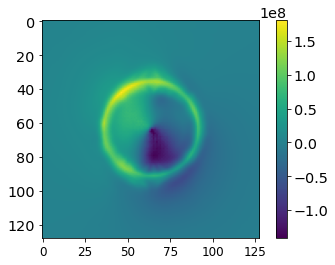

In [287]:
plt.imshow(kappa_grad.numpy().squeeze())
plt.colorbar()

<ipython-input-290-5dbb6cc15124>:18: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  axs[i, 0].annotate(fr"$t=${i * SAVE}", (0.1, 0.4), textcoords="axes fraction", size=30)


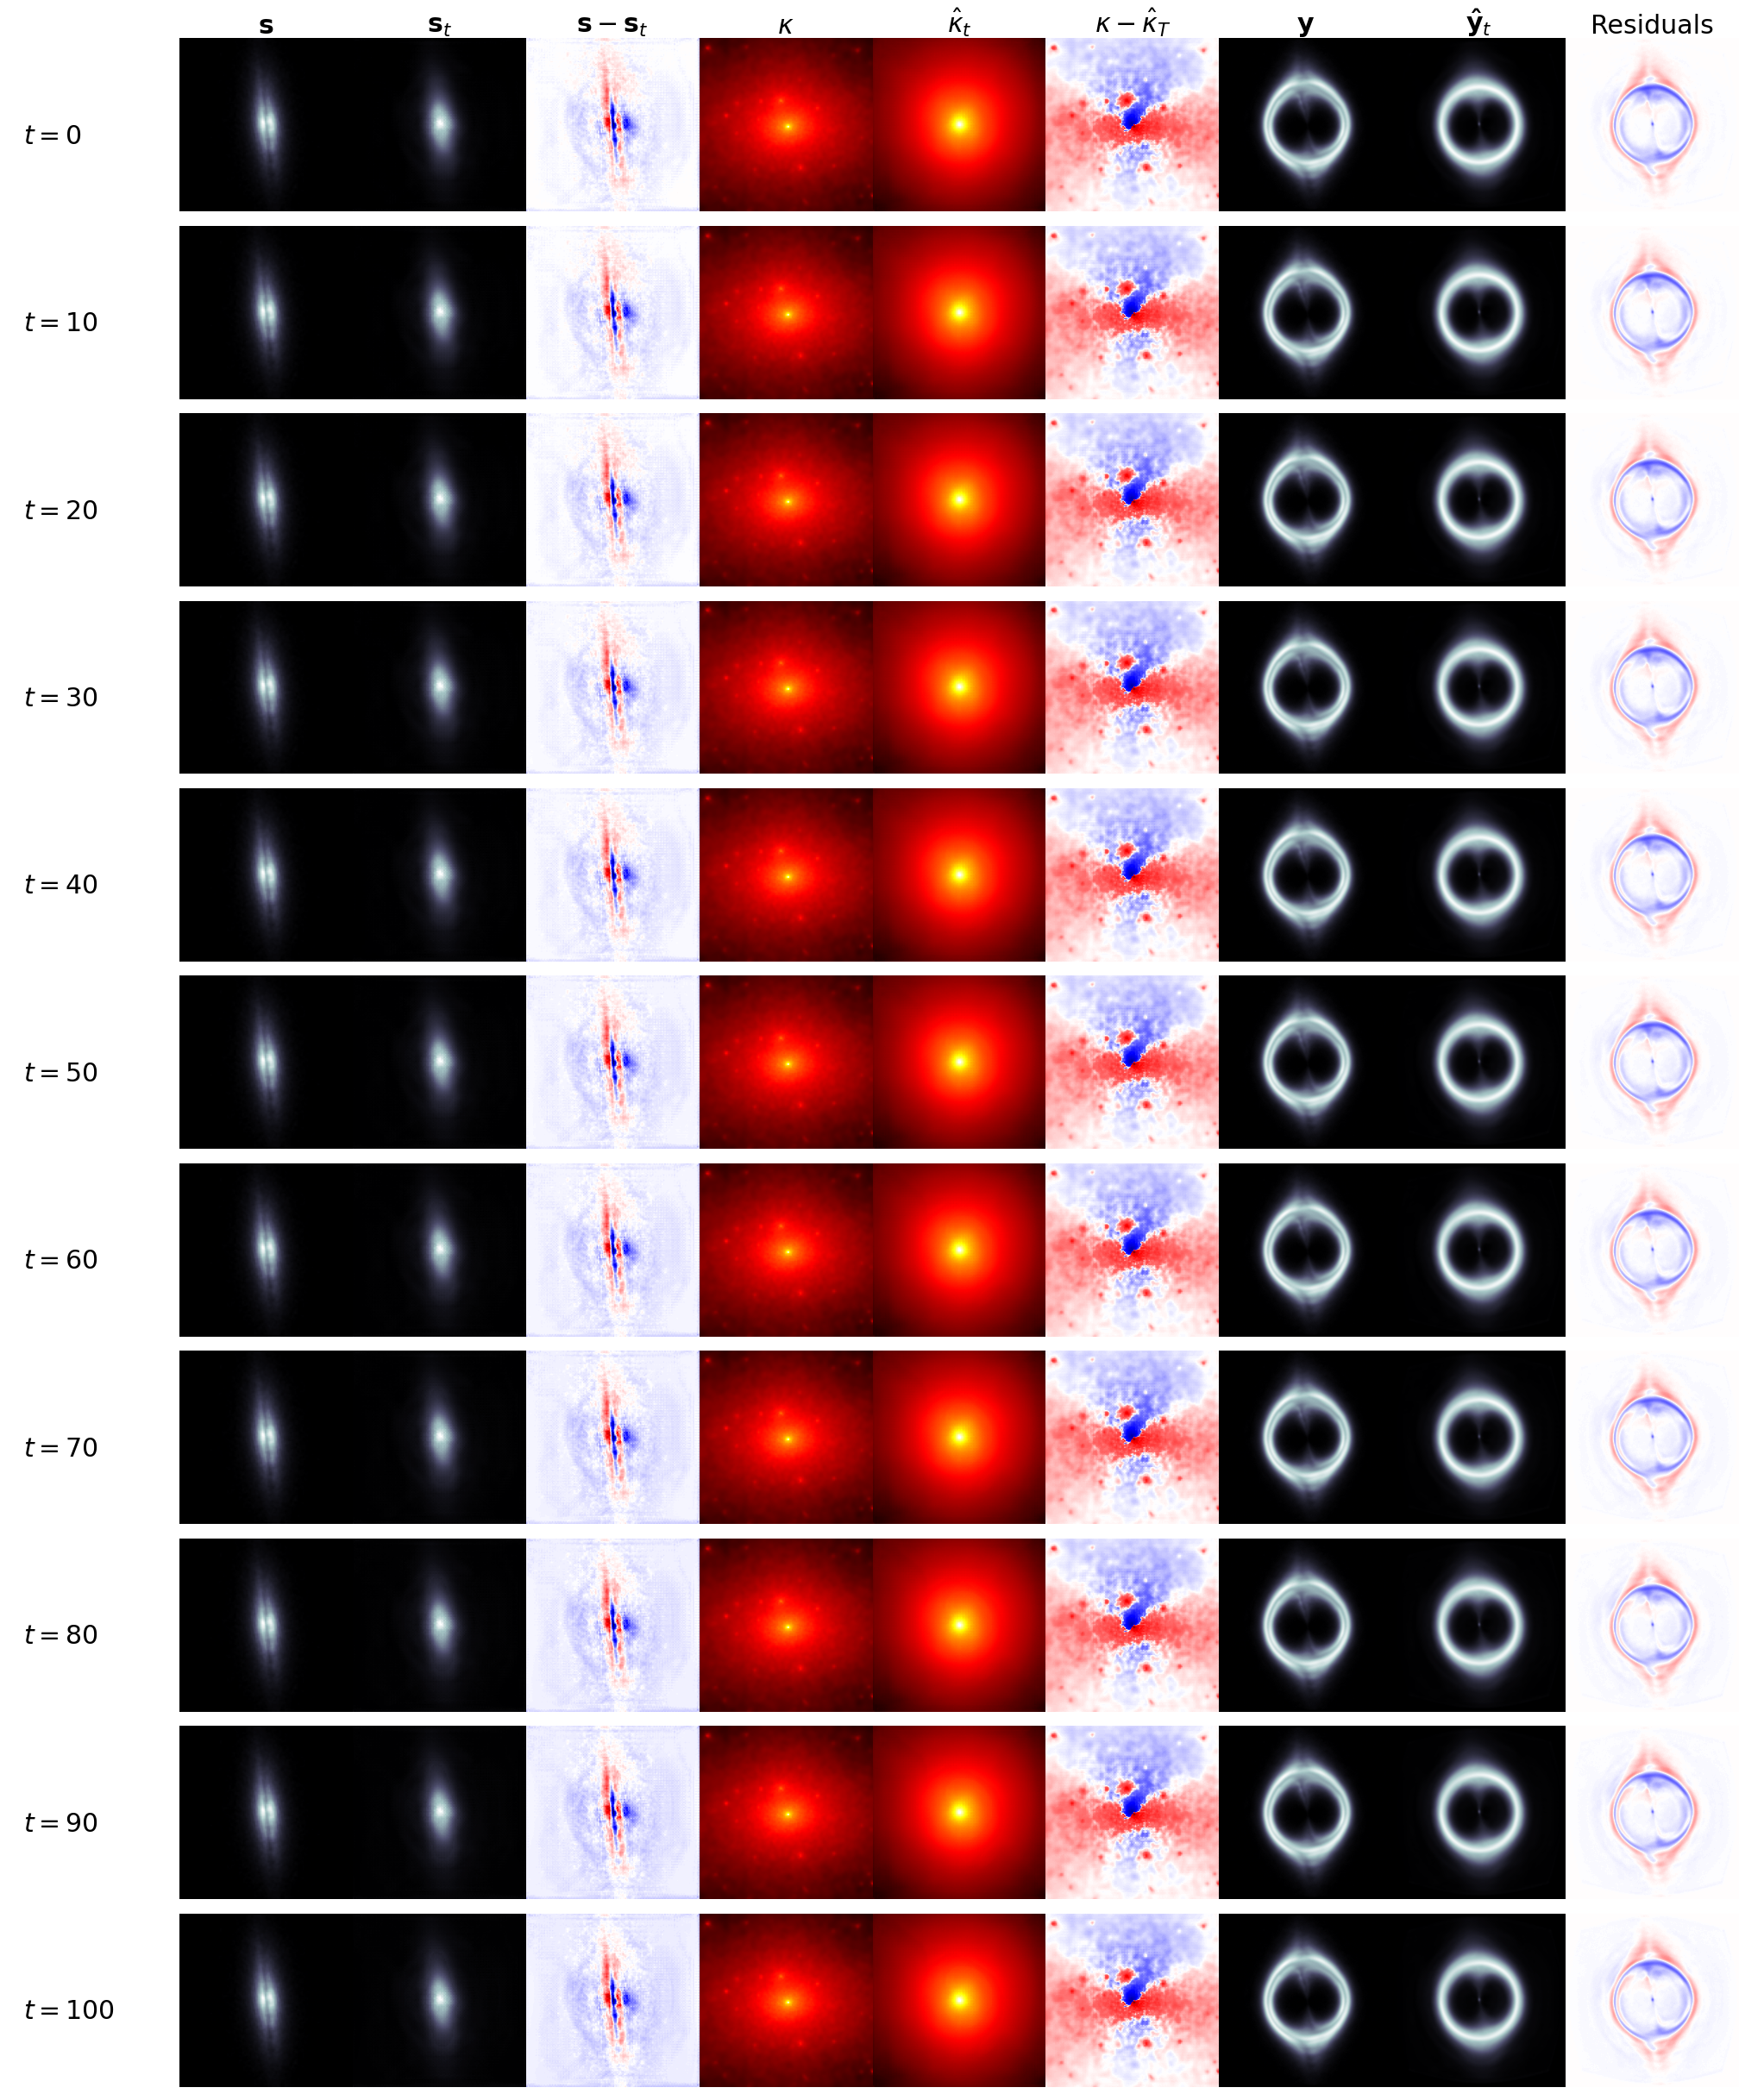

In [290]:
N = 11

fig, axs = plt.subplots(N, 10, figsize=(36, 4 * N))
for i in range(N):
    axs[i, 1].imshow(source, cmap="bone", vmin=0, vmax=1, origin="lower")
    axs[i, 2].imshow(s[i][0, ..., 0], cmap="bone", vmin=0, vmax=1, origin="lower")
    axs[i, 3].imshow(source - s[i][0, ..., 0], cmap="seismic", norm=CenteredNorm(), origin="lower")
    
    axs[i, 4].imshow(kappa, cmap="hot", norm=LogNorm(vmin=5e-2), origin="lower")
    axs[i, 5].imshow(10**k[i][0, ..., 0], cmap="hot", norm=LogNorm(vmin=5e-2), origin="lower")
    axs[i, 6].imshow(kappa - 10**k[i][0, ..., 0], cmap="seismic", norm=SymLogNorm(linthresh=1e-1, base=10, vmax=100, vmin=-100), origin="lower")
    
    axs[i, 7].imshow(lens, cmap="bone", vmin=0, origin="lower")
    axs[i, 8].imshow(y[i][0, ..., 0], cmap="bone", vmax=1,  origin="lower")
    axs[i, 9].imshow(lens - y[i][0, ..., 0], cmap="seismic", vmin=-1, vmax=1, origin="lower")
    
for i in range(N):
    axs[i, 0].annotate(fr"$t=${i * SAVE}", (0.1, 0.4), textcoords="axes fraction", size=30)
    for j in range(10):
        axs[i, j].axis("off")

axs[0, 1].set_title(r"$\mathbf{s}$")
axs[0, 2].set_title(r"$\mathbf{s}_t$")
axs[0, 3].set_title("$\mathbf{s} - \mathbf{s}_t$")
axs[0, 4].set_title("$\kappa$")
axs[0, 5].set_title("$\hat{\kappa}_t$")
axs[0, 6].set_title("$\kappa - \hat{\kappa}_T$")
axs[0, 7].set_title("$\mathbf{y}$")
axs[0, 8].set_title("$\mathbf{\hat{y}}_t$")
axs[0, 9].set_title("Residuals")
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(f"rim_pred_optim3.png")

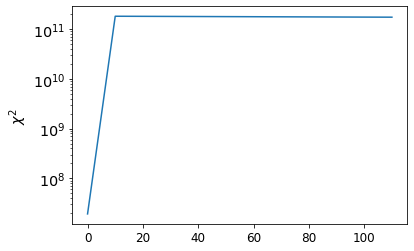

In [291]:
plt.plot(np.arange(12)*SAVE, np.concatenate([[tf.reduce_sum(tf.square(lens - lens_pred)/phys.noise_rms**2).numpy()], c.numpy().squeeze()]))
plt.ylabel(r"$\chi^2$")
plt.yscale("log")

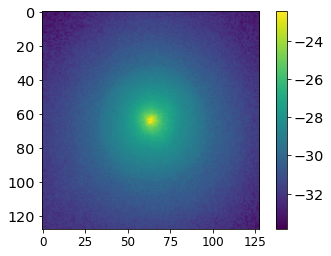

In [277]:
plt.imshow(np.log((kappa_pred - 10**k[-1][0, ..., 0]).numpy().squeeze()**2))
plt.colorbar()

In [297]:
plt.imshow((kappa - 10**k[-1])[0, ..., 0])
plt.colorbar()

TypeError: 'int' object is not subscriptable

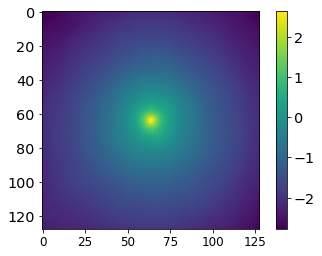

In [265]:
plt.imshow(np.log(k[-1][0, ..., 0]))
plt.colorbar()

(array([177045.,  17255.,   8882.,   6822.,   5122.,   4169.,   3524.,
          3138.,   2873.,   2735.,   2624.,   2709.,   2800.,   3127.,
          3438.,   3071.,   2884.,   2996.,   3398.,   3532.]),
 array([-8.0741628e-04,  4.8609413e-02,  9.8026238e-02,  1.4744307e-01,
         1.9685990e-01,  2.4627672e-01,  2.9569355e-01,  3.4511039e-01,
         3.9452723e-01,  4.4394404e-01,  4.9336088e-01,  5.4277772e-01,
         5.9219456e-01,  6.4161134e-01,  6.9102818e-01,  7.4044502e-01,
         7.8986186e-01,  8.3927870e-01,  8.8869548e-01,  9.3811232e-01,
         9.8752916e-01], dtype=float32),
 <BarContainer object of 20 artists>)

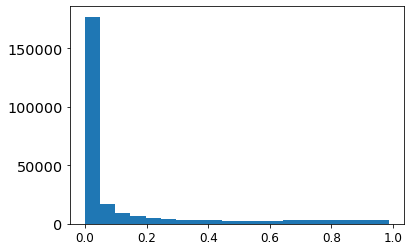

In [176]:
plt.hist(y[0].numpy().ravel(), bins=20)

(array([3.1709000e+04, 8.3759000e+04, 3.6008400e+05, 4.0760650e+07,
        6.5105559e+07, 1.0055138e+07, 6.3477470e+06, 6.9608970e+06,
        4.3382620e+06, 1.7392300e+05]),
 array([-0.8300097 , -0.65256196, -0.47511423, -0.2976665 , -0.12021875,
         0.05722898,  0.23467672,  0.41212445,  0.5895722 ,  0.7670199 ,
         0.94446766], dtype=float32),
 <BarContainer object of 10 artists>)

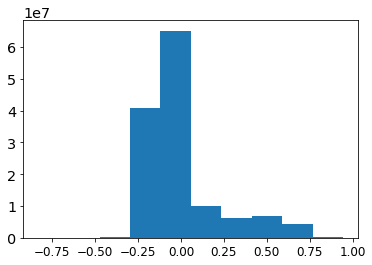

In [184]:
plt.hist((lensed_image - y[-1]).numpy().ravel())

(array([3.1709000e+04, 8.3759000e+04, 3.6008400e+05, 4.0760650e+07,
        6.5105559e+07, 1.0055138e+07, 6.3477470e+06, 6.9608970e+06,
        4.3382620e+06, 1.7392300e+05]),
 array([-0.8300097 , -0.65256196, -0.47511423, -0.2976665 , -0.12021875,
         0.05722898,  0.23467672,  0.41212445,  0.5895722 ,  0.7670199 ,
         0.94446766], dtype=float32),
 <BarContainer object of 10 artists>)

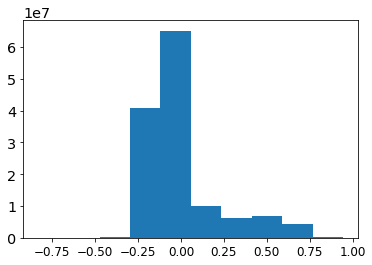

In [185]:
plt.hist((lensed_image - y_pred).numpy().ravel())

In [ ]:
f = h5py.File('yashar.h5', 'w')
g = f.create_group("rim_pred")
g.create_dataset("lens_true",        data=lens)
g.create_dataset("source_true",      data=source)
g.create_dataset("kappa_true",       data=kappa)
g.create_dataset("lens_pred",   data=lens_pred)
g.create_dataset("source_pred", data=source_pred)
g.create_dataset("kappa_pred",  data=kappa_pred)
g.create_dataset("chi_squared", data=tf.reduce_sum(tf.square(lens - lens_pred)/phys.noise_rms**2).numpy())

g = f.create_group("adam_optim")
g.create_dataset("lens",        data=y[-1].numpy().squeeze())
g.create_dataset("source",      data=s[-1].numpy().squeeze())
g.create_dataset("kappa",       data=k[-1].numpy().squeeze())
g.create_dataset("chi_squared", data=c[-1].numpy())
f.close()

In [222]:
tf.reduce_sum(tf.square(lens - lens_pred)/phys.noise_rms**2).numpy()

19257820.0

In [227]:
2*chi_squared*512**2

19257820.0